In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [27]:
train_data = datasets.FashionMNIST(
               root='C:/Users/82102',
               train=True
                ,download=True
                 ,transform=ToTensor()
)
test_data = datasets.FashionMNIST(
               root='C:/Users/82102',
               train=False
                ,download=True
                 ,transform=ToTensor()
)

# root는 학습/ 테스트 데이터 저장되는 경로 
# train : 학습용 테스트 용 데이터셋 여부 
# transform : 피처와 레이블 변형 

In [28]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [30]:
# 사용자 정의 데이터셋 만들기
import os 
import pandas as pd 
from torchvision.io import read_image
# init, len, get item 꼭 구현해야 한다 
class WooImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file, names=['file_name','label']) # label과 이미지 파일 별도로 저장
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)    # 총 데이터의 개수를 알 수 있다 
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])  # 이미지 파일 경로 파악
        image = read_image(img_path)  # 이미지 읽어오기 
        label = self.img_labels.iloc[idx,1]  # 레이블 뽑아오기 
        if self.transform:
            image = self.transform(image)    # 이미지파일 변환
        if self.target_transform:
            label = self.target_transfrom(label)  # 레이블 변환 
        return image, label

    
# init : dataset 객체가 생성될 때 실행된다 
# len: 샘플의 개수 
# getitem : idx에 해당하는 샘플을 데이터셋에서 불러오고 반환 


In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#  dataset(데이터셋의 특징을 가져오고 하나의 샘플에 정답을 지정하는 일 한번에 한다
#          학습할 때 샘플들을 미니배치로 전달 // 에폭마다 데이터를 다시 섞어서 과적합 방지
#          ) -> 이 과정을 간단하게 iterable로 만들어주는 것이 DataLoader 

In [35]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")   # batchsize = 64 / channel = 1 / 이미지의 픽셀 28*28 

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [ ]:
## transform 변형 : 데이터 조작 학습에 적합하게 만든다 
-> fashionMNIST 특징은 image 형식 + 레이블은 정수(integer)
-> 학습을 위해 정규한된 텐서 형태의 특징 feature와 부호화된 텐서 형태의 레이블이 필요 

from torchvision.transforms import ToTensor, Lambda

df = datasets.FashionMNIST(
               root='C:/Users/82102',
               train=True
                ,download=True
                 ,transform=ToTensor(),
                target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# ToTensor() : image나 numpy를 FloatTensor로 변환하고, 이미지의 픽셀의 크기값을 [0,1]범위로 scale 조정한다 
# lambda 변형 : 정수를 원핫으로 부호환된 텐서로 바꾸고 (데이터 셋 정답의 개수인) 크기 10짜리 zero tensor를 만들고 scatter 호출하여 
#               정답 y에 해당하는 인덱스에 value =1 할당 

<질문사항> 

1. lambda변형에서 왜 정답레이블을 zero tensor로 만들어서 할당하는지 모르겠습니다 
   추측: integer tensor로 하면 label이 잘나타나지 않고 zero tensor에 1 할당하는 것이 label을 잘 나타내서??? 

2. batch size 64이면 64개의 데이터가 전달되고 그 안에서 에폭마다 shuffle이 일어나서 랜덤성을 가지게 되는 건가요? 

## validation 시행 

In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [48]:
cd C:/Users/82102/Desktop\/session1-5

C:\Users\82102\Desktop\session1-5


In [37]:
def distance(x1, y1, x2, y2):
    m = (y2-y1) / (x2-x1)
    return m

In [38]:
def Coefficient(df): 
    coef = []
    for i in range(49, 351):
        frame1 = df[i][gradlab1][0:2]
        frame2 = df[i][gradlab2][0:2]
        coef.append(distance(frame1[0], frame1[1], frame2[0], frame2[1]))
    coef = pd.DataFrame(coef, columns= ['coef'])
    
    q3=coef['coef'].quantile(0.75)
    q1=coef['coef'].quantile(0.25)
    iqr=q3-q1
    outlier_top=q3+1.5*iqr
    outlier_bottom=q1-1.5*iqr
    idx=coef[(coef['coef']<outlier_bottom) | (coef['coef']>outlier_top)].index
    
    idx_list=[]
    for i in idx:
        idx_list.append(str(i))
    idx_list.append('end')

    idx_string = ' '.join(idx_list)
    idx_string_split = idx_string.split('end')
    outlier_str = idx_string_split[0].strip()
    outlier = list(map(int, outlier_str.split(' ')))

    for i in range(len(coef)-1):
        if i in outlier:
            if i == 0:
                continue
            elif i != (len(coef)-1):
                coef['coef'][i] = (coef['coef'][i-1] + coef['coef'][i+1])/2
            else:
                break
                
    coef = np.array(coef)[1:301]
    
    return coef

In [39]:
def Acceleration(pos_1, array_1, acclab):
    df = pd.DataFrame(array_1[:,acclab,:], columns=['x','y','z'])
    idx_list=[]
    for i in ['x','y','z']:
        q3=df[i].quantile(0.75)
        q1=df[i].quantile(0.25)
        iqr=q3-q1
        outlier_top=q3+1.5*iqr
        outlier_bottom=q1-1.5*iqr

        idx=df[(df[i]<outlier_bottom) | (df[i]>outlier_top)].index
        for i in idx:
            idx_list.append(str(i))
        idx_list.append('end')
    
    idx_string = ' '.join(idx_list)
    idx_string_split = idx_string.split('end')
    x_outlier_str = idx_string_split[0].strip()
    y_outlier_str = idx_string_split[1].strip()
    x_outlier = list(map(int, x_outlier_str.split(' ')[:-1]))
    y_outlier = list(map(int, y_outlier_str.split(' ')[:-1]))
    
    acc_1_parsed = array_1[:,acclab,:]
    for i in range(len(pos_1)-1):
        if i in x_outlier:
            acc_1_parsed[i][0] = (acc_1_parsed[i-1][0] + acc_1_parsed[i+1][0])/2 
        if i in y_outlier:
            acc_1_parsed[i][1] = (acc_1_parsed[i-1][1] + acc_1_parsed[i+1][1])/2 
       
    final_df = pd.DataFrame(acc_1_parsed, columns = ['x','y','z'])
    acc_array = StandardScaler().fit_transform(final_df)
    acc_array = acc_array[49:349,:]
    
    return acc_array[:,:2] 

In [40]:
hand = 'Right'
gesture_list = ['URF','UMF','ULF','DLF','DMF','DRF','URB','UMB','ULB','DLB','DMB','DRB','URO','ULO','DLO','DRO']
right_gesture = gesture_list[0]
num_session = 5
#총 세션 개수 = batch size
#5로 적어야 1~4까지 들어감

acclab1 = 8
acclab2 = 12
gradlab1 = 8
gradlab2 = 12

In [41]:
def dataloader(gesture):
    data2 = np.zeros((1,300,6))
    for i in range(1, num_session):
        data = np.zeros((300,1))
        pos = np.load('%s_%s_p_%d.npy' % (hand, gesture, i))
        acc = np.load('%s_%s_a_%d.npy' % (hand, gesture, i))
        acc1 = Acceleration(pos, acc, acclab1)
        acc2 = Acceleration(pos, acc, acclab2)
        coef = Coefficient(pos)
        if gesture == right_gesture:
            label = np.ones((300,1))
        else:
            label = np.zeros((300,1))
        data = np.hstack((data,acc1,acc2,coef,label))
        data = data[:, 1:].reshape((1,300,6))
        data2 = np.vstack((data2,data))
    
        
    return data2

In [49]:
target_data = dataloader('URF')
error_data = dataloader('DLB')

In [50]:
target_data.shape

(5, 300, 6)

In [52]:
data.shape

(8, 300, 6)

In [53]:
data = np.vstack((target_data[1:], error_data[1:]))
train_data = np.vstack((data[0], data[1], data[2], data[4], data[5], data[6]))
valid_data = np.vstack((data[3], data[7]))
train_data = train_data.reshape(6, 300, 6)
valid_data = valid_data.reshape(2, 300, 6)

In [54]:
x_train, y_train = train_data[:, :, :5], train_data[:, :, -1]
x_valid, y_valid = valid_data[:, :, :5], valid_data[:, :, -1]

In [55]:
y_train = [1, 1, 1, 1, 0, 0]
y_valid = [1, 0]

In [56]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_valid = torch.Tensor(x_valid)
y_valid = torch.Tensor(y_valid)
y_train = y_train.reshape(6, 1)

In [60]:
input_size= 5
#seq_length = 300
hidden_size = 10
num_layers = 2
dropout_rate= 0.5
num_classes = 1

In [61]:
class LSTM_Chicka(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTM_Chicka,self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.dropout_rate = dropout_rate
        self.lstm =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout_rate, batch_first = True)
        self.layer_out = nn.Linear(hidden_size, num_classes) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
    
        out, _status = self.lstm(x)
        out = self.layer_out(out[:, -1]) 
        out = self.sigmoid(out)

        return out

In [62]:
model = LSTM_Chicka(num_classes, input_size, hidden_size, num_layers, dropout_rate)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer= optimizer)

In [63]:
outputs = model(x_train)
print(outputs.shape)

torch.Size([6, 1])


In [65]:
outputs

tensor([[0.7287],
        [0.7815],
        [0.7868],
        [0.6149],
        [0.4549],
        [0.5568]], grad_fn=<SigmoidBackward0>)

In [67]:
losses= []
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs.view(-1, outputs.shape[-1]), y_train)
    loss.backward()
    optimizer.step()
    #if epoch % 10 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))
    losses.append(loss.item())


Epoch: 1, loss: 0.44088
Epoch: 2, loss: 0.43650
Epoch: 3, loss: 0.43274
Epoch: 4, loss: 0.42613
Epoch: 5, loss: 0.42036
Epoch: 6, loss: 0.40712
Epoch: 7, loss: 0.38624
Epoch: 8, loss: 0.39880
Epoch: 9, loss: 0.37191
Epoch: 10, loss: 0.38898
Epoch: 11, loss: 0.34633
Epoch: 12, loss: 0.35203
Epoch: 13, loss: 0.35105
Epoch: 14, loss: 0.34502
Epoch: 15, loss: 0.33405
Epoch: 16, loss: 0.33124
Epoch: 17, loss: 0.33033
Epoch: 18, loss: 0.31171
Epoch: 19, loss: 0.30516
Epoch: 20, loss: 0.29504
Epoch: 21, loss: 0.29721
Epoch: 22, loss: 0.28587
Epoch: 23, loss: 0.28573
Epoch: 24, loss: 0.27113
Epoch: 25, loss: 0.27480
Epoch: 26, loss: 0.27057
Epoch: 27, loss: 0.26146
Epoch: 28, loss: 0.26295
Epoch: 29, loss: 0.25461
Epoch: 30, loss: 0.25441
Epoch: 31, loss: 0.24723
Epoch: 32, loss: 0.24306
Epoch: 33, loss: 0.23395
Epoch: 34, loss: 0.24119
Epoch: 35, loss: 0.22857
Epoch: 36, loss: 0.22701
Epoch: 37, loss: 0.22422
Epoch: 38, loss: 0.22680
Epoch: 39, loss: 0.23550
Epoch: 40, loss: 0.21082
Epoch: 41

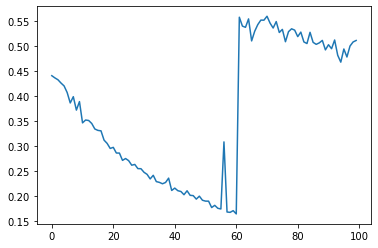

In [68]:
plt.plot(losses)
plt.show()              #  처음 100번 돌릴때는 튀는게 없었는데 다시 돌려서 100번을 또 도니까 튀는 부분이 생겼다 

In [69]:
from sklearn.metrics import accuracy_score

In [73]:
with torch.no_grad():
    model.eval()
    inputs = x_valid
    outputs = model(inputs)
    print("---------")
    print(outputs)
    outputs = outputs.detach().numpy()
    predicted = np.round(outputs)
    accuracy = (accuracy_score(predicted, y_valid))
    
print(f'accuracy는 {accuracy}')

---------
tensor([[0.8924],
        [0.2326]])
accuracy는 1.0


In [ ]:
https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f